# 021 Monophyly scores
* uses results from 016 

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from Bio import Seq, SeqIO, Align, AlignIO, Phylo, Alphabet, pairwise2 
from Bio.SeqRecord import SeqRecord
from Bio.Align import AlignInfo, Applications
from Bio.Phylo import draw, TreeConstruction  #TreeConstruction.DistanceCalculator, TreeConstruction.DistanceTreeConstructor 
# https://bioinformatics.stackexchange.com/questions/4337/biopython-phylogenetic-tree-replace-branch-tip-labels-by-sequence-logos

import numpy as np
import seaborn as sns
from sklearn import manifold, metrics, cluster, neighbors, decomposition, preprocessing
import skbio, parasail, dendropy, pandas
import sys, gzip, re, glob, pickle, collections, subprocess, os, errno, random, itertools

def print_redblack(textr, textb=""):
    print ('\x1b[0;1;31;1m'+ str(textr) + '\x1b[0;1;30;1m'+ str(textb) + '\x1b[0m')

In [2]:
##  "Mycobacterium" is not truely positive or negative
gram_positive = ["Clostridium", "Enterococcus", "Listeria", "Mycobacterium", "Staphylococcus", "Streptococcus"]
gram_negative = ["Campylobacter", "Escherichia", "Helicobacter", "Leptospira", 
                 "Neisseria", "Pseudomonas", "Salmonella"]
outdir = "./016_results/"

rrna_types = ["16S", "23S", "5S"]; hyper_types = ["16Sv1v2", "16Sv4"]
iupac_dna = {''.join(sorted(v)):k for k,v in Seq.IUPAC.IUPACData.ambiguous_dna_values.items()}
hypervar = np.array([135, 360, 540, 820, 900, 1100, 1240, 1390, 1500]) # last position, including assumed 16S size
hypervar = hypervar/hypervar[-1] # fractions, w.r.t sequence length
# https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0076185 for V1V2

### if resuming from previous analysis, run code below to read genome names table and alignments

In [49]:
ordered_types = ["5S","16Sv1v2","16Sv4","23S","16S","16S5S","23S5S","16S23S","16S23S5S"]
outfile_list = [outdir + str(keys) for keys in ordered_types] # for this data set we know order :D 
print (outfile_list)
#concat_aligned = {k:AlignIO.read(outdir + k + "_long.fasta", "fasta") for k in rrna_types+hyper_types}
#consen_aligned = {k:AlignIO.read(outdir + k + "_consensus.fasta", "fasta") for k in rrna_types+hyper_types}

['./016_results/5S', './016_results/16Sv1v2', './016_results/16Sv4', './016_results/23S', './016_results/16S', './016_results/16S5S', './016_results/23S5S', './016_results/16S23S', './016_results/16S23S5S']


In [12]:
def patristic_distances_from_treefile (filename, have_paralogs = False, shuffle = False):
    tree = dendropy.Tree.get(path=filename, schema="newick", preserve_underscores=True)
    if shuffle:
        tree = dendropy.simulate.treesim.pure_kingman_tree(taxon_namespace=tree.taxon_namespace, pop_size = 1000)
    species = ['_'.join(t.label.split('_')[:2]) for t in tree.taxon_namespace] ## follow order of taxon_namespace
    ntaxa = len(tree.taxon_namespace)
    distmat = np.zeros((ntaxa,ntaxa)) # diagonals are zero
    nodemat = np.zeros((ntaxa,ntaxa))
    pdm = tree.phylogenetic_distance_matrix() # initialises class
    for i,j in itertools.combinations(range(ntaxa),2):
        distmat[i,j] = distmat[j,i] = pdm.distance(tree.taxon_namespace[i], tree.taxon_namespace[j])
        nodemat[i,j] = nodemat[j,i] = pdm.path_edge_count(tree.taxon_namespace[i], tree.taxon_namespace[j])
    mdist = metrics.silhouette_samples(distmat, species, metric="precomputed")
    mnode = metrics.silhouette_samples(nodemat, species, metric="precomputed")
    if have_paralogs:
        sample = ['_'.join(t.label.split('_')[:3]) for t in tree.taxon_namespace]
        m3 = metrics.silhouette_samples(distmat, sample, metric="precomputed")
        m4 = metrics.silhouette_samples(nodemat, sample, metric="precomputed")
        return mdist, mnode, m3, m4
    return mdist, mnode

def silhouette_str(distrib):
    return '{:7.3f}'.format(np.percentile(distrib, 5)) + \
    '{:7.3f}'.format(np.percentile(distrib, 25)) + \
    '{:7.3f}'.format(np.percentile(distrib, 50)) + \
    '{:7.3f}  '.format(sum(distrib>0)/float(len(distrib))) 

In [50]:
mdis, mnod = patristic_distances_from_treefile (outfile_list[0]+ "_long.fasta.treefile", shuffle = True)
# bar plot uses path difference
bplot_label = ["random"] ; bplot_hue = ["proportion of good silhouette scores"]; 
bplot_value = [sum(mnod>0)/float(len(mnod))]
# violin plots use weighted distances
vio_silho_x = ["random"] * mdis.shape[0];  vio_silho_y = list(mdis)

print ('     {:12s}'.format("random"), "\t", silhouette_str(mdis),  silhouette_str(mnod))

suffix1 = ".fasta.treefile"
title1  = "ML    "
for suffix2, title2 in zip (["_long", "_consensus"], ["long ", "cons "]):
    suffix = suffix2 + suffix1; title = title2 + title1;
    for fname, rname in zip(outfile_list, [i.split('/')[-1] for i in outfile_list]):
        mdis, mnod = patristic_distances_from_treefile (fname + suffix)
        print (title + '{:6s}'.format(rname), "\t", silhouette_str(mdis),  silhouette_str(mnod))
        if "long" in title:
            bplot_label.append(rname) ; bplot_hue.append("proportion of good silhouette scores");
            bplot_value.append(sum(mnod>0)/float(len(mnod)))
            vio_silho_x.extend([str(rname)] * mdis.shape[0]); vio_silho_y.extend(list(mdis))
        

     random       	  -0.548 -0.440 -0.305  0.000    -0.352 -0.236 -0.184  0.007  
long ML    5S     	  -1.000 -1.000  0.371  0.547    -0.755 -0.430 -0.092  0.441  
long ML    16Sv1v2 	  -0.746  0.160  0.572  0.786    -0.495 -0.265 -0.016  0.483  
long ML    16Sv4  	  -0.589  0.753  0.959  0.917    -0.651 -0.328 -0.022  0.459  
long ML    23S    	  -0.064  0.531  0.726  0.945    -0.459 -0.138  0.253  0.662  
long ML    16S    	  -0.363  0.552  0.694  0.920    -0.474 -0.154  0.096  0.598  
long ML    16S5S  	  -0.234  0.492  0.645  0.920    -0.529 -0.226  0.148  0.596  
long ML    23S5S  	  -0.172  0.508  0.720  0.941    -0.458 -0.093  0.119  0.665  
long ML    16S23S 	  -0.092  0.519  0.735  0.949    -0.492 -0.013  0.243  0.748  
long ML    16S23S5S 	   0.029  0.520  0.733  0.951    -0.489  0.002  0.250  0.751  
cons ML    5S     	  -1.000 -0.997  0.622  0.600    -0.763 -0.410 -0.069  0.453  
cons ML    16Sv1v2 	  -0.725  0.259  0.797  0.819    -0.614 -0.236  0.158  0.586  
cons ML    1

In [20]:
def sp_list_from_labels (labels):
    return ['_'.join(t.split('_')[:2]) for t in labels]

def genera_set_from_namespace (txnamespace):
    x = [t.label.split('_')[0] for t in txnamespace]
    return set(x)

def taxa_list_from_strain (leaves, strain): # strain is list of species or genera
    return [x for x in leaves if strain in x]

def average_lengths_lca (samples, tre, pdm, lca): ## assumes names are unique
    taxon_label_list = [tre.find_node_with_taxon_label(x) for x in samples]
    avge = {} 
    for t in taxon_label_list:
        if t.label not in avge: ## not calculated yet
            is_mono = True
            mono_taxa = None
            while is_mono and t is not lca:
                t = t.parent_node
                taxa_below = [x for x in tre.taxon_namespace.bitmask_taxa_list(t.leafset_bitmask)]
                is_mono = all([i.label in samples for i in taxa_below])
                if (is_mono):
                    mono_taxa = [x for x in taxa_below]
            if mono_taxa:
                pairdist = np.mean([pdm.distance(i, j) for i,j in itertools.combinations(mono_taxa,2)])
                for i in mono_taxa:
                    avge[i.label] = pairdist
            else:
                avge[t.label] = 0.
    return max([v for k,v in avge.items()])

def monophyly_score_from_treefile (filename, shuffle = False):
    tree = dendropy.Tree.get(path=filename, schema="newick", preserve_underscores=True)
    if shuffle:
        x = tree.length()
        tree = dendropy.simulate.treesim.pure_kingman_tree(taxon_namespace=tree.taxon_namespace, pop_size = 5000)
        for edge in tree.preorder_edge_iter():
            edge.length = edge.length/x
    else: 
        tree.reroot_at_midpoint(update_bipartitions=True)
    tree.encode_bipartitions()
    pdm = tree.phylogenetic_distance_matrix() # initialises patristic distance class
    leaf_list = [x.label for x in tree.taxon_namespace]
    freq_species = []
    monoscore = []
    max_avge = []
    for sp in set(sp_list_from_labels(leaf_list)):
        samples_from_sp = taxa_list_from_strain (leaf_list, sp)
        mrca = tree.mrca(taxon_labels=samples_from_sp)
        samples_below_mrca = [x.label for x in tree.taxon_namespace.bitmask_taxa_list(mrca.leafset_bitmask)]
        samples_above_mrca = [x for x in leaf_list if x not in samples_below_mrca]
        try:
            m1 = len(samples_from_sp)/len(samples_below_mrca)
        except:
            m1 = len(samples_from_sp)/len(samples_above_mrca)
        monoscore.append(m1)
        try:
            m1 = 1./len(set(sp_list_from_labels(samples_below_mrca)))
        except:
            m1 = 1./len(set(sp_list_from_labels(samples_above_mrca)))
        freq_species.append(m1)
        max_avge.append(average_lengths_lca (samples_from_sp, tree, pdm, mrca))
        #print (samples_above_mrca)
    return monoscore, freq_species, max_avge

def mono_str(mono_, freq_, mav_):
    return '{:7.3f}'.format(np.percentile(mono_, 25)) + \
    '{:7.3f}\t'.format(np.percentile(mono_, 50)) + \
    '{:7.3f}\t\t'.format(sum(np.array(freq_) > 0.999)/float(len(freq_))) + \
    '{:.12f}\t'.format(np.percentile(mav_, 50)) + \
    '{:.12f}\t'.format(np.percentile(mav_, 95))

#mono, fspec = monophyly_score_from_treefile (outfile_list[8]+ "_long.fasta.treefile", shuffle = False)

In [51]:
mono, fspec, mav = monophyly_score_from_treefile (outfile_list[0]+ "_long.fasta.treefile", shuffle = True)
print ('{:17s}'.format("random"), "\t", mono_str(mono, fspec, mav))
bplot_label.append("random") ; bplot_hue.append("proportion of monophyletic groups")
bplot_value.append(sum(np.array(fspec) > 0.999)/float(len(fspec)))
vio_mono_x = ["random"] * len(mono)
vio_mono_y = mono; vio_mav_y = mav

suffix1 = ".fasta.treefile"
title1  = "ML    "
for suffix2, title2 in zip (["_long", "_consensus"], ["long ", "cons "]):
    suffix = suffix2 + suffix1; title = title2 + title1;
    for fname, rname in zip(outfile_list, [i.split('/')[-1] for i in outfile_list]):
        mono, fspec, mav = monophyly_score_from_treefile (fname + suffix)
        print (title + '{:7s}'.format(rname), "\t", mono_str(mono, fspec, mav))
        if "long" in title:
            bplot_label.append(rname) ; bplot_hue.append("proportion of monophyletic groups")
            bplot_value.append(sum(np.array(fspec) > 0.999)/float(len(fspec)))
            vio_mono_x.extend([rname] * len(mono))
            vio_mono_y.extend(mono); vio_mav_y.extend(mav);

random            	   0.005  0.008	  0.000		0.000000000000	0.000000000000	
long ML    5S      	   0.043  0.155	  0.138		0.000000000000	0.003984585677	
long ML    16Sv1v2 	   0.081  0.333	  0.207		0.000000000000	0.007985780237	
long ML    16Sv4   	   0.106  0.473	  0.276		0.000000000000	0.002927466667	
long ML    23S     	   0.176  0.964	  0.448		0.002099133333	0.026691013699	
long ML    16S     	   0.161  1.000	  0.552		0.003238800000	0.025299445865	
long ML    16S5S   	   0.100  1.000	  0.517		0.002120666667	0.024665467078	
long ML    23S5S   	   0.152  0.991	  0.483		0.002126666667	0.028652936997	
long ML    16S23S  	   0.246  0.964	  0.448		0.004514400000	0.026261626667	
long ML    16S23S5S 	   0.500  1.000	  0.517		0.007446340900	0.032202374781	
cons ML    5S      	   0.059  0.160	  0.172		0.000000000000	0.004560623921	
cons ML    16Sv1v2 	   0.083  0.400	  0.276		0.000004279000	0.011103698363	
cons ML    16Sv4   	   0.114  0.600	  0.379		0.000003095733	0.005922586646	
cons ML    2

Text(0.5, 1.0, 'proportion of sample pairs with good silhouettes and proportion of monophyletic groups')

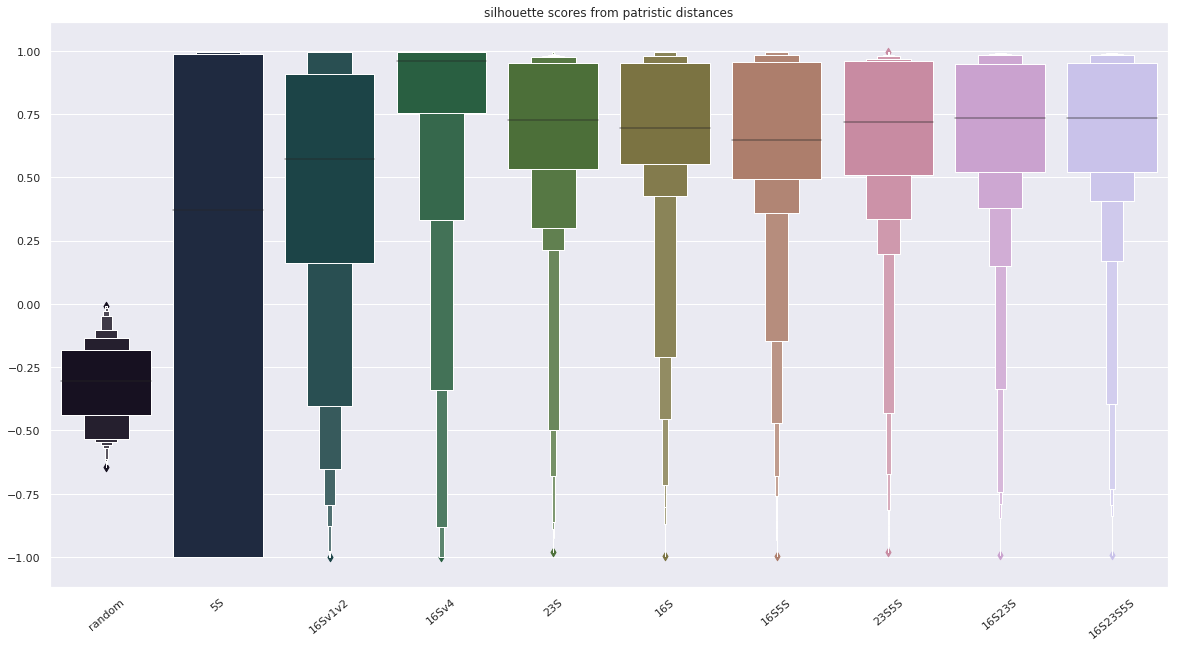

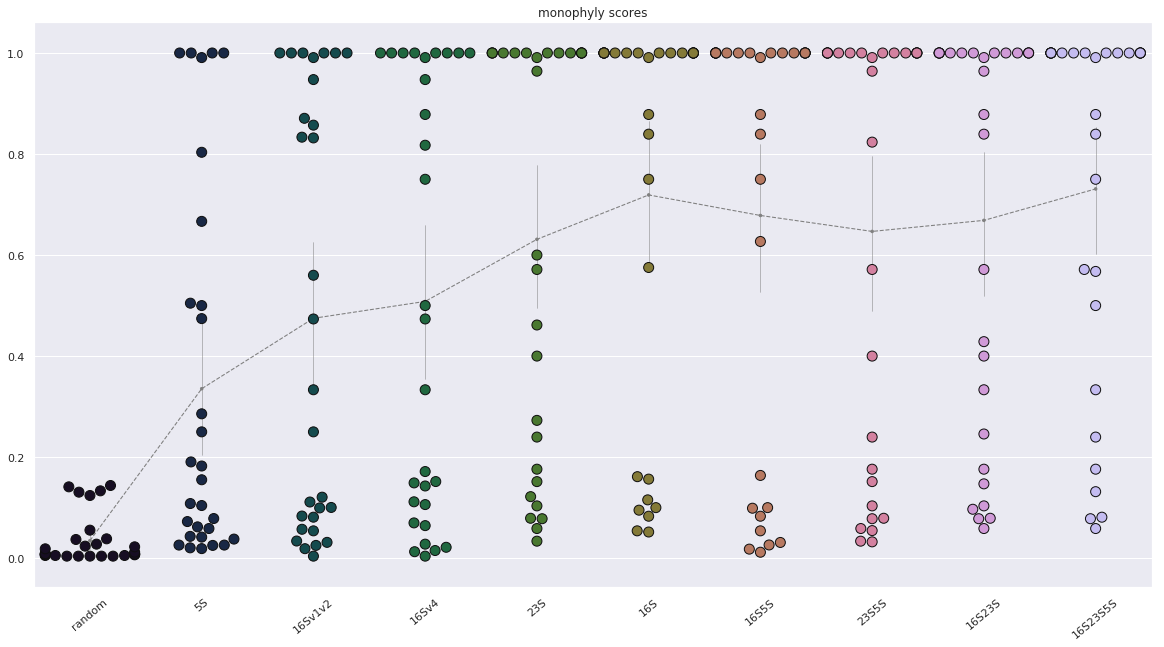

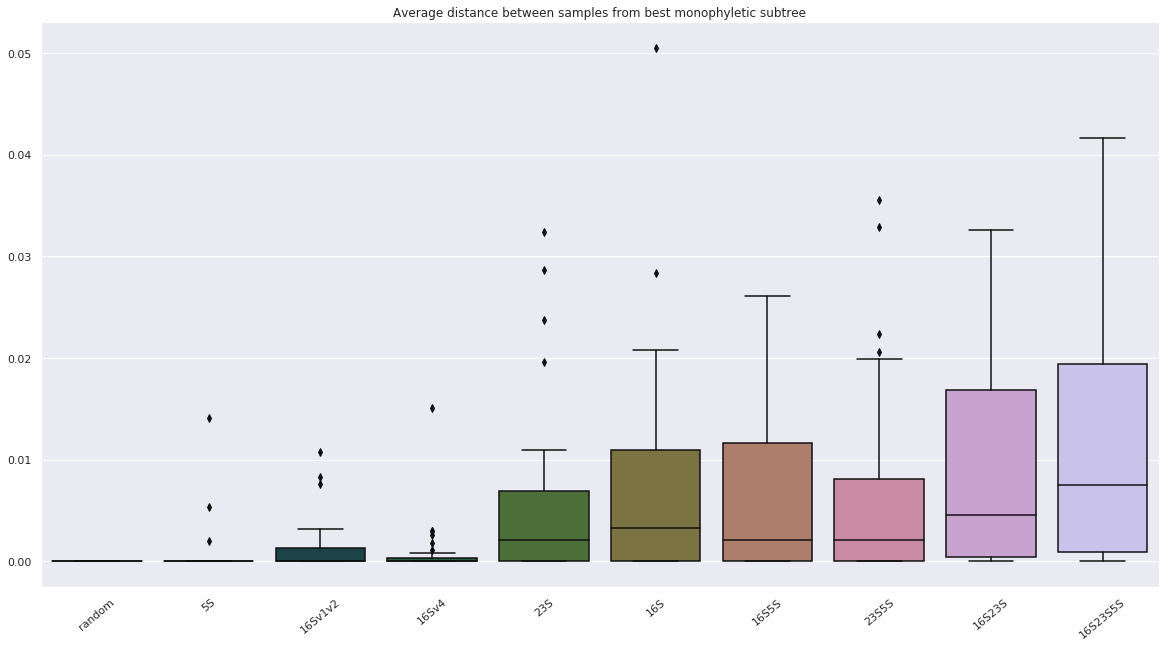

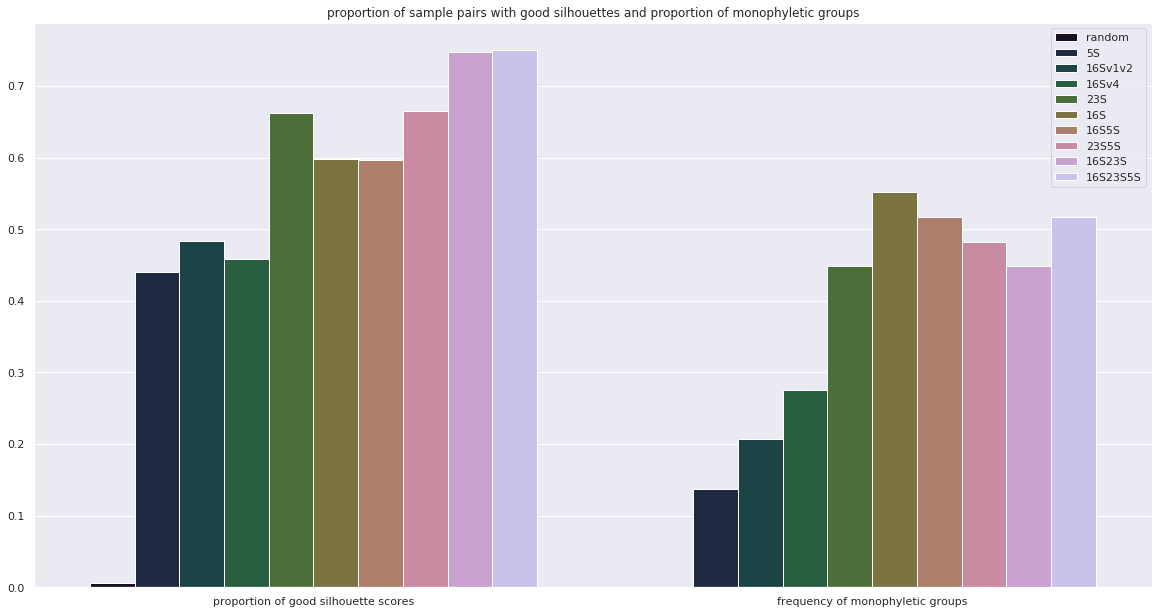

In [63]:
fig, axes = plt.subplots(1) ; fig.set_size_inches(16, 8); 
fig.subplots_adjust(top=.99, bottom=.01, left=.01, right=.98, wspace=.2, hspace=.2)
sns.set(); sns.set_palette("cubehelix", 12)
sns.boxenplot(x=vio_silho_x, y=vio_silho_y, ax = axes, outlier_prop=0.00001)
axes.set_title("silhouette scores from patristic distances")
axes.set_xticklabels(axes.get_xticklabels(),rotation=40)

fig, axes = plt.subplots(1) ; fig.set_size_inches(16, 8); 
fig.subplots_adjust(top=.99, bottom=.01, left=.01, right=.98, wspace=.2, hspace=.2)
sns.set(); sns.set_palette("cubehelix", 12)
sns.pointplot(x=vio_mono_x, y=vio_mono_y, ax = axes, linestyles="--", errwidth=0.5, color="gray", scale=0.4)
sns.swarmplot(x=vio_mono_x, y=vio_mono_y, ax = axes, size=10, linewidth=1)
axes.set_title("monophyly scores")
axes.set_xticklabels(axes.get_xticklabels(),rotation=40)

fig, axes = plt.subplots(1) ; fig.set_size_inches(16, 8); 
fig.subplots_adjust(top=.99, bottom=.01, left=.01, right=.98, wspace=.2, hspace=.2)
sns.set(); sns.set_palette("cubehelix", 12)
sns.boxplot(x=vio_mono_x, y=vio_mav_y, ax = axes)
axes.set_title("Average distance between samples from best monophyletic subtree")
axes.set_xticklabels(axes.get_xticklabels(),rotation=40)
#sns.boxplot(x=rnatypelist, y=monolist_sp, ax = axes[1])  # inner="sticks",
#sns.pointplot(x=rnatypelist, y=monolist_sp, ax = axes[1])  


fig, axes = plt.subplots(1) ; fig.set_size_inches(16, 8); 
fig.subplots_adjust(top=.99, bottom=.01, left=.01, right=.98, wspace=.2, hspace=.2)
sns.set(); sns.set_palette("cubehelix", 12)
sns.barplot(hue=bplot_label, y=bplot_value, x=bplot_hue, ax=axes)
axes.set_title("proportion of sample pairs with good silhouettes and proportion of monophyletic groups")